In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import os

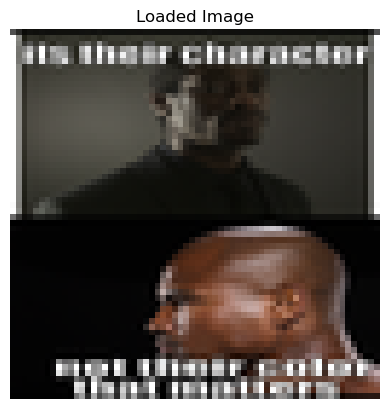

벡터화된 이미지 텐서:
tensor([[[-1.0048, -1.0048, -1.1589,  ..., -1.1075, -1.0048, -1.0048],
         [-1.0048, -1.0048, -1.1589,  ..., -1.1075, -1.0048, -1.0048],
         [-0.4397, -0.4397, -0.6452,  ..., -0.6109, -0.4397, -0.4397],
         ...,
         [-1.3473, -1.3473, -1.3473,  ..., -2.1179, -2.1179, -2.1179],
         [-1.6213, -1.6213, -1.6213,  ..., -2.1179, -2.1179, -2.1179],
         [-1.6213, -1.6213, -1.6213,  ..., -2.1179, -2.1179, -2.1179]],

        [[-0.8978, -0.8978, -1.0553,  ..., -1.0028, -0.8978, -0.8978],
         [-0.8978, -0.8978, -1.0553,  ..., -1.0028, -0.8978, -0.8978],
         [-0.3200, -0.3200, -0.5301,  ..., -0.4951, -0.3200, -0.3200],
         ...,
         [-1.4580, -1.4580, -1.4580,  ..., -2.0357, -2.0357, -2.0357],
         [-1.6681, -1.6681, -1.6681,  ..., -2.0357, -2.0357, -2.0357],
         [-1.6681, -1.6681, -1.6681,  ..., -2.0357, -2.0357, -2.0357]],

        [[-0.6715, -0.6715, -0.8284,  ..., -0.8110, -0.6715, -0.6715],
         [-0.6715, -0.6715, -0.8

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# 이미지 경로 및 로드
img_path = os.path.join("osai-project", "train/42953.png")  # 테스트용 이미지
image = Image.open(img_path).convert('RGB')

# 이미지 시각화
plt.imshow(image)
plt.title("Loaded Image")
plt.axis('off')
plt.show()

# 이미지 텐서 변환
image_transforms = transforms.Compose([
    #transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_tensor = image_transforms(image)  # 이미지 변환
print("벡터화된 이미지 텐서:")
print(image_tensor)
print(f"텐서 크기: {image_tensor.shape}")  # (채널, 높이, 너비)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

import os
import pandas as pd
from PIL import Image

# Mixed Precision
from torch.cuda.amp import autocast, GradScaler

# =====================
# DistilBERT (HF)
# =====================
from transformers import DistilBertTokenizer, DistilBertModel

# =====================
# PARAMS
# =====================
MAX_LEN = 128
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
#LEARNING_RATE = 2e-5
NUM_EPOCHS = 12  # 예시
THRESHOLDS = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# =====================
# 1) Dataset
# =====================
class Multimodal(Dataset):
    """
    CSV 컬럼 예시: id, img, label, text
      - id: 샘플 id
      - img: 경로 (e.g. "train/xxxx.png")
      - label: 0 or 1 (Train/Val) / Test에서는 사용 안 할 수도 있음
      - text: "문장"
    """
    def __init__(self, csv_file, img_base_path, is_test=False):
        """
        Args:
            csv_file (str): CSV 파일 경로
            img_base_path (str): 이미지가 위치한 상위 폴더 경로
            is_test (bool): test 셋일 때 True (label 없는 경우도 고려)
        """
        self.data = pd.read_csv(csv_file)
        self.img_base_path = img_base_path
        self.is_test = is_test

        # DistilBERT 토크나이저
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

        # 이미지 전처리
        self.transform = transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225]
            ),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # --- ID
        sample_id = row['id']

        # --- Image
        img_path = os.path.join(self.img_base_path, row['img'])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # --- Text
        text_str = str(row['text'])
        encoding = self.tokenizer(
            text_str,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)         # shape: (MAX_LEN,)
        attention_mask = encoding['attention_mask'].squeeze(0)

        # --- Label (Train/Val 경우)
        if not self.is_test:
            # label이 있는 경우 float으로
            label = torch.tensor(row['label'], dtype=torch.float)
        else:
            # test 셋이면 label이 없거나 dummy일 수 있음
            label = torch.tensor(0.0)

        return {
            'id': sample_id,
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label
        }


# =====================
# 2) Model
# =====================
class MultimodalClassifier(nn.Module):
    """
    이미지 인코더: EfficientNet-B0 (pretrained)
      - 마지막 분류 레이어 제거 -> 1280 차원 특징 추출
    텍스트 인코더: DistilBertModel (pretrained)
      - [CLS] 토큰 임베딩 (768차원)
    결합: (1280 + 768) → Linear 블록 → 출력 1 (이진분류)
    """
    def __init__(self):
        super(MultimodalClassifier, self).__init__()
        # (1) EfficientNet-B0
        self.image_encoder = models.efficientnet_b0(pretrained=True)
        #   - classifier 부분을 날려서 feature만 추출
        self.image_encoder.classifier = nn.Identity()  # (B, 1280)

        # (2) DistilBERT
        self.text_encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # (3) Classifier (concatenate -> linear)
        self.classifier = nn.Sequential(
            nn.Linear(1280 + 768, 512),
            nn.GELU(),
            #nn.Dropout(p=0.5)
            nn.Dropout(p=0.8),
            nn.Linear(512, 64),
            nn.GELU(),
            #nn.Dropout(p=0.3)
            nn.Dropout(p=0.6),
            nn.Linear(64, 1)  # 1차원 로짓 (binary)
        )

    def forward(self, images, input_ids, attention_mask):
        # (a) Image features
        img_features = self.image_encoder(images)  # (B,1280)

        # (b) Text features
        text_outputs = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # DistilBertModel: last_hidden_state shape (B, seq_len, hidden_dim=768)
        # [CLS] 토큰 = hidden_state[:,0,:]
        text_features = text_outputs.last_hidden_state[:, 0, :]  # (B,768)

        # (c) Concat
        combined = torch.cat((img_features, text_features), dim=1)  # (B, 2048)

        # (d) Classifier
        logits = self.classifier(combined)  # (B,1)
        return logits


# =====================
# 3) Train Function
# =====================
def train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )

    scaler = GradScaler()  # Mixed precision
    best_val_acc = 0.0
    best_threshold = 0.5

    for epoch in range(num_epochs):
        # ----------
        # Training
        # ----------
        model.train()
        running_loss = 0.0
        total, correct = 0, 0

        for batch_idx, batch in enumerate(train_loader):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)  # (B,) float

            optimizer.zero_grad()
            with autocast():
                logits = model(images, input_ids, attention_mask)  # (B,1)
                loss = criterion(logits.squeeze(), labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            with torch.no_grad():
                # 기본 threshold=0.5로 train set accuracy 대략 체크
                preds = (torch.sigmoid(logits.squeeze()) >= 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total

        # ----------
        # Validation
        #    여러 threshold 시도
        # ----------
        model.eval()
        val_loss = 0.0

        # logits/labels 모아서 threshold별 accuracy를 한번에 계산
        val_logits_list = []
        val_labels_list = []

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                out_logits = model(images, input_ids, attention_mask)  # (B,1)
                loss = criterion(out_logits.squeeze(), labels)
                val_loss += loss.item()

                val_logits_list.append(out_logits.squeeze().cpu())
                val_labels_list.append(labels.cpu())

        val_logits_tensor = torch.cat(val_logits_list, dim=0)   # (N,)
        val_labels_tensor = torch.cat(val_labels_list, dim=0)   # (N,)

        # threshold 별 accuracy 측정
        threshold_accuracies = {}
        for th in THRESHOLDS:
            preds = (torch.sigmoid(val_logits_tensor) >= th).float()
            correct_count = (preds == val_labels_tensor).sum().item()
            acc = 100.0 * correct_count / len(val_labels_tensor)
            threshold_accuracies[th] = acc

        # 가장 높은 accuracy와 threshold 찾기
        best_th, best_th_acc = max(threshold_accuracies.items(), key=lambda x: x[1])
        avg_val_loss = val_loss / len(val_loader)

        # 스케줄러 업데이트 (기준: best_th_acc)
        scheduler.step(best_th_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f" Train Loss: {avg_train_loss:.4f} | Train Acc (0.5 thr): {train_acc:.2f}%")
        print(f" Val   Loss: {avg_val_loss:.4f}")
        for th in sorted(THRESHOLDS):
            print(f"   Thr={th:.2f} | Val Acc={threshold_accuracies[th]:.2f}%")
        print(f" => Best Thr={best_th:.2f}, Best Thr Acc={best_th_acc:.2f}%")

        # Best Model Save
        if best_th_acc > best_val_acc:
            best_val_acc = best_th_acc
            best_threshold = best_th
            checkpoint = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'best_threshold': best_threshold
            }
            torch.save(checkpoint, "best_model.pth")
            print(f"*** Best Model Saved! val_acc={best_val_acc:.2f}%, thr={best_threshold:.2f}\n")
        else:
            print()

        torch.cuda.empty_cache()

    print(f"Training Completed! Best Val Acc={best_val_acc:.2f}%, Threshold={best_threshold:.2f}")
    return best_val_acc, best_threshold


# =====================
# 4) Test Inference
# =====================
def predict_testset(model, test_csv, img_base_path, threshold, out_csv="solution.csv"):
    """
    1) Load test dataset
    2) Use the best model & threshold for prediction
    3) Save results as csv (id, label)
       - label은 0 또는 1
    """
    test_dataset = Multimodal(test_csv, img_base_path, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model.eval()
    model.to(device)

    ids_list = []
    preds_list = []

    with torch.no_grad():
        for batch in test_loader:
            sample_ids = batch['id']
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            logits = model(images, input_ids, attention_mask)  # (B,1)
            proba = torch.sigmoid(logits.squeeze())            # (B,)

            preds = (proba >= threshold).long().cpu()          # 0 or 1
            # 저장
            for s_id, pred_label in zip(sample_ids, preds):
                ids_list.append(s_id.item())   # id가 int 형식일 경우
                preds_list.append(pred_label.item())

    # CSV로 저장
    df_out = pd.DataFrame({"id": ids_list, "label": preds_list})
    df_out.to_csv(out_csv, index=False)
    print(f"Test inference completed. Saved results to '{out_csv}'")


# =====================
# 5) main (실행 예시)
# =====================
def main():
    # CSV 경로 예시
    train_csv = "osai-project/train_text_label_1.csv"
    val_csv   = "osai-project/val_text_label.csv"
    test_csv  = "osai-project/test_text_label.csv"  # 최종 예측용
    img_base_path = "osai-project"                  # 실제로는 "osai-project/train" 등으로 구성 가능

    # (1) 전체 Train+Val 데이터셋 로딩
    #     여기서는 예시로 별도 CSV가 있다면 각각 Dataset을 만듦
    train_dataset = Multimodal(train_csv, img_base_path, is_test=False)
    val_dataset   = Multimodal(val_csv,   img_base_path, is_test=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # (2) 모델 생성
    model = MultimodalClassifier()

    # (3) 학습
    best_val_acc, best_threshold = train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS)

    # (4) Best 모델 & Threshold 불러오기
    checkpoint = torch.load("best_model.pth", map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    best_threshold = checkpoint["best_threshold"]

    print(f"\nLoaded Best Model: val_acc={checkpoint['best_val_acc']:.2f}%, thr={best_threshold:.2f}")

    # (5) Test 예측
    predict_testset(model, test_csv, img_base_path, threshold=best_threshold, out_csv="solution.csv")


if __name__ == "__main__":
    main()


/usr/anaconda3/envs/env1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/anaconda3/envs/env1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/anaconda3/envs/env1/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_1586072/2049076197.py:178: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.a

Epoch [1/12]
 Train Loss: 0.6435 | Train Acc (0.5 thr): 63.59%
 Val   Loss: 0.6723
   Thr=0.30 | Val Acc=60.25%
   Thr=0.35 | Val Acc=60.61%
   Thr=0.40 | Val Acc=61.60%
   Thr=0.45 | Val Acc=62.82%
   Thr=0.50 | Val Acc=61.84%
   Thr=0.55 | Val Acc=60.74%
   Thr=0.60 | Val Acc=53.37%
   Thr=0.65 | Val Acc=51.78%
   Thr=0.70 | Val Acc=51.78%
 => Best Thr=0.45, Best Thr Acc=62.82%
*** Best Model Saved! val_acc=62.82%, thr=0.45



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [2/12]
 Train Loss: 0.5536 | Train Acc (0.5 thr): 74.49%
 Val   Loss: 0.6392
   Thr=0.30 | Val Acc=70.43%
   Thr=0.35 | Val Acc=70.31%
   Thr=0.40 | Val Acc=68.34%
   Thr=0.45 | Val Acc=66.26%
   Thr=0.50 | Val Acc=63.93%
   Thr=0.55 | Val Acc=62.70%
   Thr=0.60 | Val Acc=60.37%
   Thr=0.65 | Val Acc=58.53%
   Thr=0.70 | Val Acc=57.55%
 => Best Thr=0.30, Best Thr Acc=70.43%
*** Best Model Saved! val_acc=70.43%, thr=0.30



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [3/12]
 Train Loss: 0.4958 | Train Acc (0.5 thr): 78.21%
 Val   Loss: 0.5690
   Thr=0.30 | Val Acc=72.64%
   Thr=0.35 | Val Acc=72.76%
   Thr=0.40 | Val Acc=74.11%
   Thr=0.45 | Val Acc=73.62%
   Thr=0.50 | Val Acc=71.66%
   Thr=0.55 | Val Acc=69.69%
   Thr=0.60 | Val Acc=67.73%
   Thr=0.65 | Val Acc=65.40%
   Thr=0.70 | Val Acc=63.80%
 => Best Thr=0.40, Best Thr Acc=74.11%
*** Best Model Saved! val_acc=74.11%, thr=0.40



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [4/12]
 Train Loss: 0.4429 | Train Acc (0.5 thr): 80.74%
 Val   Loss: 0.5452
   Thr=0.30 | Val Acc=76.32%
   Thr=0.35 | Val Acc=77.30%
   Thr=0.40 | Val Acc=76.44%
   Thr=0.45 | Val Acc=75.09%
   Thr=0.50 | Val Acc=73.50%
   Thr=0.55 | Val Acc=70.55%
   Thr=0.60 | Val Acc=68.10%
   Thr=0.65 | Val Acc=66.63%
   Thr=0.70 | Val Acc=64.79%
 => Best Thr=0.35, Best Thr Acc=77.30%
*** Best Model Saved! val_acc=77.30%, thr=0.35



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [5/12]
 Train Loss: 0.3949 | Train Acc (0.5 thr): 83.23%
 Val   Loss: 0.4779
   Thr=0.30 | Val Acc=77.30%
   Thr=0.35 | Val Acc=78.65%
   Thr=0.40 | Val Acc=79.39%
   Thr=0.45 | Val Acc=79.88%
   Thr=0.50 | Val Acc=79.26%
   Thr=0.55 | Val Acc=77.55%
   Thr=0.60 | Val Acc=73.99%
   Thr=0.65 | Val Acc=71.66%
   Thr=0.70 | Val Acc=69.45%
 => Best Thr=0.45, Best Thr Acc=79.88%
*** Best Model Saved! val_acc=79.88%, thr=0.45



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [6/12]
 Train Loss: 0.3503 | Train Acc (0.5 thr): 85.10%
 Val   Loss: 0.4508
   Thr=0.30 | Val Acc=80.74%
   Thr=0.35 | Val Acc=81.84%
   Thr=0.40 | Val Acc=83.19%
   Thr=0.45 | Val Acc=83.44%
   Thr=0.50 | Val Acc=81.23%
   Thr=0.55 | Val Acc=76.93%
   Thr=0.60 | Val Acc=74.11%
   Thr=0.65 | Val Acc=69.57%
   Thr=0.70 | Val Acc=67.12%
 => Best Thr=0.45, Best Thr Acc=83.44%
*** Best Model Saved! val_acc=83.44%, thr=0.45



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [7/12]
 Train Loss: 0.3150 | Train Acc (0.5 thr): 86.80%
 Val   Loss: 0.3996
   Thr=0.30 | Val Acc=81.60%
   Thr=0.35 | Val Acc=83.19%
   Thr=0.40 | Val Acc=84.05%
   Thr=0.45 | Val Acc=85.03%
   Thr=0.50 | Val Acc=85.52%
   Thr=0.55 | Val Acc=83.44%
   Thr=0.60 | Val Acc=80.49%
   Thr=0.65 | Val Acc=75.09%
   Thr=0.70 | Val Acc=70.31%
 => Best Thr=0.50, Best Thr Acc=85.52%
*** Best Model Saved! val_acc=85.52%, thr=0.50



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [8/12]
 Train Loss: 0.2796 | Train Acc (0.5 thr): 88.78%
 Val   Loss: 0.3501
   Thr=0.30 | Val Acc=83.56%
   Thr=0.35 | Val Acc=84.54%
   Thr=0.40 | Val Acc=86.38%
   Thr=0.45 | Val Acc=86.99%
   Thr=0.50 | Val Acc=87.61%
   Thr=0.55 | Val Acc=87.73%
   Thr=0.60 | Val Acc=87.61%
   Thr=0.65 | Val Acc=80.74%
   Thr=0.70 | Val Acc=74.36%
 => Best Thr=0.55, Best Thr Acc=87.73%
*** Best Model Saved! val_acc=87.73%, thr=0.55



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [9/12]
 Train Loss: 0.2416 | Train Acc (0.5 thr): 90.33%
 Val   Loss: 0.3177
   Thr=0.30 | Val Acc=87.48%
   Thr=0.35 | Val Acc=87.36%
   Thr=0.40 | Val Acc=88.10%
   Thr=0.45 | Val Acc=88.59%
   Thr=0.50 | Val Acc=89.94%
   Thr=0.55 | Val Acc=89.33%
   Thr=0.60 | Val Acc=87.98%
   Thr=0.65 | Val Acc=84.05%
   Thr=0.70 | Val Acc=78.77%
 => Best Thr=0.50, Best Thr Acc=89.94%
*** Best Model Saved! val_acc=89.94%, thr=0.50



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

Epoch [10/12]
 Train Loss: 0.2201 | Train Acc (0.5 thr): 91.80%
 Val   Loss: 0.2661
   Thr=0.30 | Val Acc=90.92%
   Thr=0.35 | Val Acc=92.02%
   Thr=0.40 | Val Acc=92.52%
   Thr=0.45 | Val Acc=92.76%
   Thr=0.50 | Val Acc=92.39%
   Thr=0.55 | Val Acc=91.17%
   Thr=0.60 | Val Acc=90.55%
   Thr=0.65 | Val Acc=88.34%
   Thr=0.70 | Val Acc=82.09%
 => Best Thr=0.45, Best Thr Acc=92.76%
*** Best Model Saved! val_acc=92.76%, thr=0.45



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [11/12]
 Train Loss: 0.1920 | Train Acc (0.5 thr): 92.86%
 Val   Loss: 0.2263
   Thr=0.30 | Val Acc=91.04%
   Thr=0.35 | Val Acc=91.53%
   Thr=0.40 | Val Acc=92.02%
   Thr=0.45 | Val Acc=92.64%
   Thr=0.50 | Val Acc=93.01%
   Thr=0.55 | Val Acc=94.23%
   Thr=0.60 | Val Acc=93.87%
   Thr=0.65 | Val Acc=93.50%
   Thr=0.70 | Val Acc=92.02%
 => Best Thr=0.55, Best Thr Acc=94.23%
*** Best Model Saved! val_acc=94.23%, thr=0.55



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [12/12]
 Train Loss: 0.1642 | Train Acc (0.5 thr): 94.01%
 Val   Loss: 0.2075
   Thr=0.30 | Val Acc=91.66%
   Thr=0.35 | Val Acc=92.27%
   Thr=0.40 | Val Acc=92.27%
   Thr=0.45 | Val Acc=92.64%
   Thr=0.50 | Val Acc=93.01%
   Thr=0.55 | Val Acc=93.37%
   Thr=0.60 | Val Acc=94.11%
   Thr=0.65 | Val Acc=94.36%
   Thr=0.70 | Val Acc=94.23%
 => Best Thr=0.65, Best Thr Acc=94.36%
*** Best Model Saved! val_acc=94.36%, thr=0.65

Training Completed! Best Val Acc=94.36%, Threshold=0.65


/tmp/ipykernel_1586072/2049076197.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", map_location=device)



Loaded Best Model: val_acc=94.36%, thr=0.65
Test inference completed. Saved results to 'solution.csv'


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

import os
import pandas as pd
from PIL import Image

# Mixed Precision
from torch.cuda.amp import autocast, GradScaler

# =====================
# DistilBERT (HF)
# =====================
from transformers import DistilBertTokenizer, DistilBertModel

# =====================
# PARAMS
# =====================
MAX_LEN = 128
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
#LEARNING_RATE = 2e-5
NUM_EPOCHS = 12  # 예시
THRESHOLDS = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# =====================
# 1) Dataset
# =====================
class Multimodal(Dataset):
    """
    CSV 컬럼 예시: id, img, label, text
      - id: 샘플 id
      - img: 경로 (e.g. "train/xxxx.png")
      - label: 0 or 1 (Train/Val) / Test에서는 사용 안 할 수도 있음
      - text: "문장"
    """
    def __init__(self, csv_file, img_base_path, is_test=False):
        """
        Args:
            csv_file (str): CSV 파일 경로
            img_base_path (str): 이미지가 위치한 상위 폴더 경로
            is_test (bool): test 셋일 때 True (label 없는 경우도 고려)
        """
        self.data = pd.read_csv(csv_file)
        self.img_base_path = img_base_path
        self.is_test = is_test

        # DistilBERT 토크나이저
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

        # 이미지 전처리
        self.transform = transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225]
            ),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # --- ID
        sample_id = row['id']

        # --- Image
        img_path = os.path.join(self.img_base_path, row['img'])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # --- Text
        text_str = str(row['text'])
        encoding = self.tokenizer(
            text_str,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)         # shape: (MAX_LEN,)
        attention_mask = encoding['attention_mask'].squeeze(0)

        # --- Label (Train/Val 경우)
        if not self.is_test:
            # label이 있는 경우 float으로
            label = torch.tensor(row['label'], dtype=torch.float)
        else:
            # test 셋이면 label이 없거나 dummy일 수 있음
            label = torch.tensor(0.0)

        return {
            'id': sample_id,
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label
        }


# =====================
# 2) Model
# =====================
class MultimodalClassifier(nn.Module):
    """
    이미지 인코더: EfficientNet-B0 (pretrained)
      - 마지막 분류 레이어 제거 -> 1280 차원 특징 추출
    텍스트 인코더: DistilBertModel (pretrained)
      - [CLS] 토큰 임베딩 (768차원)
    결합: (1280 + 768) → Linear 블록 → 출력 1 (이진분류)
    """
    def __init__(self):
        super(MultimodalClassifier, self).__init__()
        # (1) EfficientNet-B0
        self.image_encoder = models.efficientnet_b0(pretrained=True)
        #   - classifier 부분을 날려서 feature만 추출
        self.image_encoder.classifier = nn.Identity()  # (B, 1280)

        # (2) DistilBERT
        self.text_encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # (3) Classifier (concatenate -> linear)
        self.classifier = nn.Sequential(
            nn.Linear(1280 + 768, 512),
            nn.GELU(),
            #nn.Dropout(p=0.5)
            nn.Dropout(p=0.8),
            nn.Linear(512, 64),
            nn.GELU(),
            #nn.Dropout(p=0.3)
            nn.Dropout(p=0.6),
            nn.Linear(64, 1)  # 1차원 로짓 (binary)
        )

    def forward(self, images, input_ids, attention_mask):
        # (a) Image features
        img_features = self.image_encoder(images)  # (B,1280)

        # (b) Text features
        text_outputs = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # DistilBertModel: last_hidden_state shape (B, seq_len, hidden_dim=768)
        # [CLS] 토큰 = hidden_state[:,0,:]
        text_features = text_outputs.last_hidden_state[:, 0, :]  # (B,768)

        # (c) Concat
        combined = torch.cat((img_features, text_features), dim=1)  # (B, 2048)

        # (d) Classifier
        logits = self.classifier(combined)  # (B,1)
        return logits


# =====================
# 3) Train Function
# =====================
def train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )

    scaler = GradScaler()  # Mixed precision
    best_val_acc = 0.0
    best_threshold = 0.5

    for epoch in range(num_epochs):
        # ----------
        # Training
        # ----------
        model.train()
        running_loss = 0.0
        total, correct = 0, 0

        for batch_idx, batch in enumerate(train_loader):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)  # (B,) float

            optimizer.zero_grad()
            with autocast():
                logits = model(images, input_ids, attention_mask)  # (B,1)
                loss = criterion(logits.squeeze(), labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            with torch.no_grad():
                # 기본 threshold=0.5로 train set accuracy 대략 체크
                preds = (torch.sigmoid(logits.squeeze()) >= 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total

        # ----------
        # Validation
        #    여러 threshold 시도
        # ----------
        model.eval()
        val_loss = 0.0

        # logits/labels 모아서 threshold별 accuracy를 한번에 계산
        val_logits_list = []
        val_labels_list = []

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                out_logits = model(images, input_ids, attention_mask)  # (B,1)
                loss = criterion(out_logits.squeeze(), labels)
                val_loss += loss.item()

                val_logits_list.append(out_logits.squeeze().cpu())
                val_labels_list.append(labels.cpu())

        val_logits_tensor = torch.cat(val_logits_list, dim=0)   # (N,)
        val_labels_tensor = torch.cat(val_labels_list, dim=0)   # (N,)

        # threshold 별 accuracy 측정
        threshold_accuracies = {}
        for th in THRESHOLDS:
            preds = (torch.sigmoid(val_logits_tensor) >= th).float()
            correct_count = (preds == val_labels_tensor).sum().item()
            acc = 100.0 * correct_count / len(val_labels_tensor)
            threshold_accuracies[th] = acc

        # 가장 높은 accuracy와 threshold 찾기
        best_th, best_th_acc = max(threshold_accuracies.items(), key=lambda x: x[1])
        avg_val_loss = val_loss / len(val_loader)

        # 스케줄러 업데이트 (기준: best_th_acc)
        scheduler.step(best_th_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f" Train Loss: {avg_train_loss:.4f} | Train Acc (0.5 thr): {train_acc:.2f}%")
        print(f" Val   Loss: {avg_val_loss:.4f}")
        for th in sorted(THRESHOLDS):
            print(f"   Thr={th:.2f} | Val Acc={threshold_accuracies[th]:.2f}%")
        print(f" => Best Thr={best_th:.2f}, Best Thr Acc={best_th_acc:.2f}%")

        # Best Model Save
        if best_th_acc > best_val_acc:
            best_val_acc = best_th_acc
            best_threshold = best_th
            checkpoint = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'best_threshold': best_threshold
            }
            torch.save(checkpoint, "best_model.pth")
            print(f"*** Best Model Saved! val_acc={best_val_acc:.2f}%, thr={best_threshold:.2f}\n")
        else:
            print()

        torch.cuda.empty_cache()

    print(f"Training Completed! Best Val Acc={best_val_acc:.2f}%, Threshold={best_threshold:.2f}")
    return best_val_acc, best_threshold


# =====================
# 4) Test Inference
# =====================
def predict_testset(model, test_csv, img_base_path, threshold, out_csv="solution.csv"):
    """
    1) Load test dataset
    2) Use the best model & threshold for prediction
    3) Save results as csv (id, label)
       - label은 0 또는 1
    """
    test_dataset = Multimodal(test_csv, img_base_path, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model.eval()
    model.to(device)

    ids_list = []
    preds_list = []

    with torch.no_grad():
        for batch in test_loader:
            sample_ids = batch['id']
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            logits = model(images, input_ids, attention_mask)  # (B,1)
            proba = torch.sigmoid(logits.squeeze())            # (B,)

            preds = (proba >= threshold).long().cpu()          # 0 or 1
            # 저장
            for s_id, pred_label in zip(sample_ids, preds):
                ids_list.append(s_id.item())   # id가 int 형식일 경우
                preds_list.append(pred_label.item())

    # CSV로 저장
    df_out = pd.DataFrame({"id": ids_list, "label": preds_list})
    df_out.to_csv(out_csv, index=False)
    print(f"Test inference completed. Saved results to '{out_csv}'")


# =====================
# 5) main (실행 예시)
# =====================
def main():
    # CSV 경로 예시
    train_csv = "osai-project/train_text_label_1.csv"
    val_csv   = "osai-project/test_text_label_1.csv"
    test_csv  = "osai-project/test_text_label_1.csv"  # 최종 예측용
    img_base_path = "osai-project"                  # 실제로는 "osai-project/train" 등으로 구성 가능

    # (1) 전체 Train+Val 데이터셋 로딩
    #     여기서는 예시로 별도 CSV가 있다면 각각 Dataset을 만듦
    train_dataset = Multimodal(train_csv, img_base_path, is_test=False)
    val_dataset   = Multimodal(val_csv,   img_base_path, is_test=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # (2) 모델 생성
    model = MultimodalClassifier()

    # (3) 학습
    best_val_acc, best_threshold = train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS)

    # (4) Best 모델 & Threshold 불러오기
    checkpoint = torch.load("best_model.pth", map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    best_threshold = checkpoint["best_threshold"]

    print(f"\nLoaded Best Model: val_acc={checkpoint['best_val_acc']:.2f}%, thr={best_threshold:.2f}")

    # (5) Test 예측
    predict_testset(model, test_csv, img_base_path, threshold=best_threshold, out_csv="solution.csv")


if __name__ == "__main__":
    main()


/usr/anaconda3/envs/env1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/anaconda3/envs/env1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/anaconda3/envs/env1/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_1586072/2186319196.py:178: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.a

Epoch [1/12]
 Train Loss: 0.6472 | Train Acc (0.5 thr): 63.42%
 Val   Loss: 0.6502
   Thr=0.30 | Val Acc=55.30%
   Thr=0.35 | Val Acc=58.51%
   Thr=0.40 | Val Acc=61.02%
   Thr=0.45 | Val Acc=62.08%
   Thr=0.50 | Val Acc=63.09%
   Thr=0.55 | Val Acc=63.90%
   Thr=0.60 | Val Acc=62.34%
   Thr=0.65 | Val Acc=62.34%
   Thr=0.70 | Val Acc=62.34%
 => Best Thr=0.55, Best Thr Acc=63.90%
*** Best Model Saved! val_acc=63.90%, thr=0.55



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [2/12]
 Train Loss: 0.5616 | Train Acc (0.5 thr): 74.41%
 Val   Loss: 0.6538
   Thr=0.30 | Val Acc=61.96%
   Thr=0.35 | Val Acc=64.28%
   Thr=0.40 | Val Acc=64.72%
   Thr=0.45 | Val Acc=64.03%
   Thr=0.50 | Val Acc=63.47%
   Thr=0.55 | Val Acc=63.84%
   Thr=0.60 | Val Acc=64.28%
   Thr=0.65 | Val Acc=63.84%
   Thr=0.70 | Val Acc=63.53%
 => Best Thr=0.40, Best Thr Acc=64.72%
*** Best Model Saved! val_acc=64.72%, thr=0.40



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [3/12]
 Train Loss: 0.4977 | Train Acc (0.5 thr): 77.63%
 Val   Loss: 0.6878
   Thr=0.30 | Val Acc=63.34%
   Thr=0.35 | Val Acc=64.41%
   Thr=0.40 | Val Acc=64.85%
   Thr=0.45 | Val Acc=64.72%
   Thr=0.50 | Val Acc=65.10%
   Thr=0.55 | Val Acc=64.16%
   Thr=0.60 | Val Acc=64.22%
   Thr=0.65 | Val Acc=64.22%
   Thr=0.70 | Val Acc=63.84%
 => Best Thr=0.50, Best Thr Acc=65.10%
*** Best Model Saved! val_acc=65.10%, thr=0.50



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [4/12]
 Train Loss: 0.4461 | Train Acc (0.5 thr): 80.96%
 Val   Loss: 0.6531
   Thr=0.30 | Val Acc=61.08%
   Thr=0.35 | Val Acc=62.59%
   Thr=0.40 | Val Acc=63.28%
   Thr=0.45 | Val Acc=64.85%
   Thr=0.50 | Val Acc=64.09%
   Thr=0.55 | Val Acc=65.03%
   Thr=0.60 | Val Acc=64.53%
   Thr=0.65 | Val Acc=63.72%
   Thr=0.70 | Val Acc=63.47%
 => Best Thr=0.55, Best Thr Acc=65.03%



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [5/12]
 Train Loss: 0.3948 | Train Acc (0.5 thr): 82.83%
 Val   Loss: 0.6914
   Thr=0.30 | Val Acc=63.03%
   Thr=0.35 | Val Acc=64.03%
   Thr=0.40 | Val Acc=64.28%
   Thr=0.45 | Val Acc=64.72%
   Thr=0.50 | Val Acc=64.60%
   Thr=0.55 | Val Acc=65.66%
   Thr=0.60 | Val Acc=64.85%
   Thr=0.65 | Val Acc=64.85%
   Thr=0.70 | Val Acc=64.09%
 => Best Thr=0.55, Best Thr Acc=65.66%
*** Best Model Saved! val_acc=65.66%, thr=0.55



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [6/12]
 Train Loss: 0.3552 | Train Acc (0.5 thr): 84.95%
 Val   Loss: 0.7027
   Thr=0.30 | Val Acc=63.34%
   Thr=0.35 | Val Acc=64.72%
   Thr=0.40 | Val Acc=66.23%
   Thr=0.45 | Val Acc=65.10%
   Thr=0.50 | Val Acc=65.47%
   Thr=0.55 | Val Acc=66.23%
   Thr=0.60 | Val Acc=65.29%
   Thr=0.65 | Val Acc=64.47%
   Thr=0.70 | Val Acc=64.60%
 => Best Thr=0.40, Best Thr Acc=66.23%
*** Best Model Saved! val_acc=66.23%, thr=0.40



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/

Epoch [7/12]
 Train Loss: 0.3065 | Train Acc (0.5 thr): 87.04%
 Val   Loss: 0.7446
   Thr=0.30 | Val Acc=64.72%
   Thr=0.35 | Val Acc=65.47%
   Thr=0.40 | Val Acc=66.16%
   Thr=0.45 | Val Acc=66.48%
   Thr=0.50 | Val Acc=67.55%
   Thr=0.55 | Val Acc=67.42%
   Thr=0.60 | Val Acc=66.60%
   Thr=0.65 | Val Acc=65.91%
   Thr=0.70 | Val Acc=64.47%
 => Best Thr=0.50, Best Thr Acc=67.55%
*** Best Model Saved! val_acc=67.55%, thr=0.50



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

Epoch [8/12]
 Train Loss: 0.2746 | Train Acc (0.5 thr): 88.64%
 Val   Loss: 0.7345
   Thr=0.30 | Val Acc=64.53%
   Thr=0.35 | Val Acc=66.35%
   Thr=0.40 | Val Acc=67.48%
   Thr=0.45 | Val Acc=67.98%
   Thr=0.50 | Val Acc=69.37%
   Thr=0.55 | Val Acc=69.05%
   Thr=0.60 | Val Acc=67.86%
   Thr=0.65 | Val Acc=66.23%
   Thr=0.70 | Val Acc=64.78%
 => Best Thr=0.50, Best Thr Acc=69.37%
*** Best Model Saved! val_acc=69.37%, thr=0.50



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [9/12]
 Train Loss: 0.2391 | Train Acc (0.5 thr): 90.74%
 Val   Loss: 0.7584
   Thr=0.30 | Val Acc=63.59%
   Thr=0.35 | Val Acc=64.72%
   Thr=0.40 | Val Acc=66.04%
   Thr=0.45 | Val Acc=67.29%
   Thr=0.50 | Val Acc=68.80%
   Thr=0.55 | Val Acc=69.55%
   Thr=0.60 | Val Acc=69.93%
   Thr=0.65 | Val Acc=69.68%
   Thr=0.70 | Val Acc=68.05%
 => Best Thr=0.60, Best Thr Acc=69.93%
*** Best Model Saved! val_acc=69.93%, thr=0.60



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

Epoch [10/12]
 Train Loss: 0.2075 | Train Acc (0.5 thr): 92.01%
 Val   Loss: 0.7705
   Thr=0.30 | Val Acc=66.23%
   Thr=0.35 | Val Acc=66.67%
   Thr=0.40 | Val Acc=68.30%
   Thr=0.45 | Val Acc=69.24%
   Thr=0.50 | Val Acc=70.24%
   Thr=0.55 | Val Acc=70.87%
   Thr=0.60 | Val Acc=71.37%
   Thr=0.65 | Val Acc=71.50%
   Thr=0.70 | Val Acc=68.11%
 => Best Thr=0.65, Best Thr Acc=71.50%
*** Best Model Saved! val_acc=71.50%, thr=0.65



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [11/12]
 Train Loss: 0.1835 | Train Acc (0.5 thr): 93.13%
 Val   Loss: 0.8838
   Thr=0.30 | Val Acc=66.35%
   Thr=0.35 | Val Acc=67.04%
   Thr=0.40 | Val Acc=67.92%
   Thr=0.45 | Val Acc=68.55%
   Thr=0.50 | Val Acc=69.11%
   Thr=0.55 | Val Acc=69.99%
   Thr=0.60 | Val Acc=71.56%
   Thr=0.65 | Val Acc=72.19%
   Thr=0.70 | Val Acc=72.07%
 => Best Thr=0.65, Best Thr Acc=72.19%
*** Best Model Saved! val_acc=72.19%, thr=0.65



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch [12/12]
 Train Loss: 0.1633 | Train Acc (0.5 thr): 93.90%
 Val   Loss: 0.9128
   Thr=0.30 | Val Acc=66.42%
   Thr=0.35 | Val Acc=67.80%
   Thr=0.40 | Val Acc=68.17%
   Thr=0.45 | Val Acc=69.11%
   Thr=0.50 | Val Acc=69.49%
   Thr=0.55 | Val Acc=70.18%
   Thr=0.60 | Val Acc=70.75%
   Thr=0.65 | Val Acc=71.37%
   Thr=0.70 | Val Acc=71.94%
 => Best Thr=0.70, Best Thr Acc=71.94%

Training Completed! Best Val Acc=72.19%, Threshold=0.65


/tmp/ipykernel_1586072/2186319196.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", map_location=device)



Loaded Best Model: val_acc=72.19%, thr=0.65
Test inference completed. Saved results to 'solution.csv'
